Import libraries

In [1]:
import gzip
import itertools
import json
import pathlib
import time

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

You will need to run the NLTK (natural language toolkit) `download` function to download additional items for using `nltk`.

In [2]:
run_nltk_downloader = False

if run_nltk_downloader:
    nltk.download()

The data is stored in JSON (JavaScript Object Notation) format. The JSON file is compressed to save space. The following code block shows how to read the data.

In [3]:
raw_data_filepath = pathlib.Path('relevant_data.json.gz')

with gzip.GzipFile(raw_data_filepath, 'r') as fp:
    json_bytes = fp.read()
    json_str = json_bytes.decode('utf-8')
    tweet_data = json.loads(json_str)
    
print(f'The data includes {len(tweet_data)} observations.')

The data includes 434578 observations.


The data is stored as a list of lists. Each sublist has six items:
1. the datetime for the tweet,
2. the username associated with the tweet,
3. the user associated with the tweet,
4. the location associated with the tweet,
5. the language associated with the tweet, and
6. the tweet text.

The following code block prints the first entry as an example.

In [4]:
tweet_data[0]

['Sat Mar 28 08:21:12 +0000 2020',
 'DianeB67082104',
 'Diane B',
 'Yorkshire and The Humber',
 'en',
 '@redviking_82 Yea we are fine staying home as much as we can Hubby has to go to work (keyworker food production) and we shop for his parents I stay in the car. His Mum likes to see me ❤️ Stay safe love xx']

The following code block:
1. creates a Pandas `DataFrame` with the data (named `tweet_df`),
2. converts the `Datetime` column to a datetime format,
3. creates a `Date` column with just the date extracted from the `Datetime` column,
4. creates a `Day_Name` column that specifies the day of the week that the tweet was posted.
5. creates a `Weekend` column that is `True` if the tweet was posted on a weekend, and `False` otherwise.

In [5]:
column_names = [
    'Datetime',
    'Username',
    'User',
    'Location',
    'Language',
    'Text',
]

tweet_df = pd.DataFrame(tweet_data, 
                        columns = column_names)

tweet_df['Datetime'] = pd.to_datetime(tweet_df['Datetime'], 
                                      format = '%a %b %d %H:%M:%S %z %Y')

tweet_df['Date'] = tweet_df['Datetime'].dt.date

tweet_df['Day_Name'] = tweet_df['Datetime'].dt.day_name()

weekend_mask = tweet_df['Day_Name'].isin(['Saturday', 'Sunday'])
tweet_df.loc[weekend_mask, 'Weekend'] = True
tweet_df.loc[~weekend_mask, 'Weekend'] = False

tweet_df['Hour'] = tweet_df['Datetime'].dt.hour

In [6]:
tweet_df.head()

,Datetime,Username,User,Location,Language,Text,Date,Day_Name,Weekend,Hour
0,2020-03-28 08:21:12+00:00,DianeB67082104,Diane B,Yorkshire and The Humber,en,@redviking_82 Yea we are fine staying home as ...,2020-03-28,Saturday,True,8
1,2020-03-28 09:07:14+00:00,BiotechPolicyUK,Michael M. Hopkins,"Brighton, UK",en,This is a helpful analysis of NERVTAG delibera...,2020-03-28,Saturday,True,9
2,2020-03-28 00:14:05+00:00,MarketingEdgeM,Marketing Edge,"Lagos, Nigeria",en,"Kantar, the world’s leading data, insights and...",2020-03-28,Saturday,True,0
3,2020-03-28 05:36:36+00:00,Mrtroublelex,Raynomics,"Warri, Nigeria",en,"@iRuntown__ I been like you well well, but all...",2020-03-28,Saturday,True,5
4,2020-03-28 11:10:05+00:00,whitedragoncom,Kin Dle,None,en,Jesus Christ Christian Bible Prophecy News - F...,2020-03-28,Saturday,True,11


The following code block shows the number of missing values in the data (expressed as a proportion of the total number of observations).

In [7]:
tweet_df.isna().sum()/len(tweet_df)

Datetime    0.000000
Username    0.000000
User        0.000000
Location    0.293694
Language    0.000000
Text        0.000000
Date        0.000000
Day_Name    0.000000
Weekend     0.000000
Hour        0.000000
dtype: float64

The following code block plots the number of tweets collected each day (recall this is just a sample).

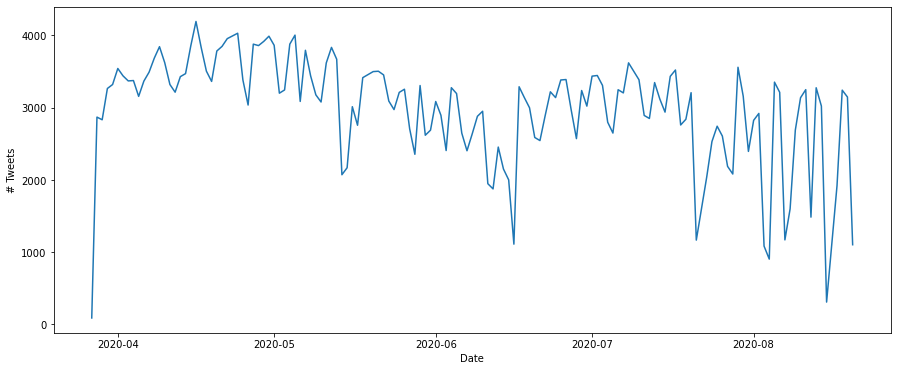

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))

temp = tweet_df.groupby(['Date'])['Text'].count().reset_index()
temp = temp.rename(columns = {'Text': '# Tweets'})

sns.lineplot(
    x = 'Date', 
    y = '# Tweets',
    data = temp,
)

plt.show()

The following code block generates a plot that shows how the average number of tweets posted a day varies by day of the week.

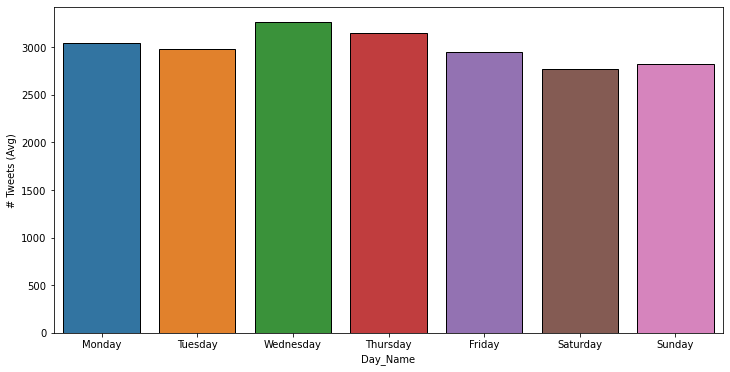

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

temp = tweet_df.groupby(['Date', 'Day_Name'])['Text'].count().reset_index()
temp = temp.groupby(['Day_Name'])['Text'].mean().reset_index()
temp = temp.rename(columns = {'Text': '# Tweets (Avg)'})

sns.barplot(
    x = 'Day_Name', 
    y = '# Tweets (Avg)',
    data = temp,
    edgecolor = 'k',
    order = ['Monday', 
             'Tuesday',
             'Wednesday',
             'Thursday',
             'Friday',
             'Saturday',
             'Sunday',
            ]
)

plt.show()

The following code block generates a plot that shows how the average number of tweets posted a day varies by hour of day.

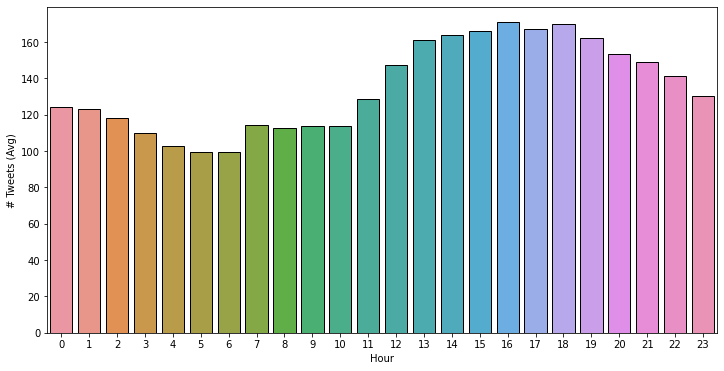

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

temp = tweet_df.groupby(['Date', 'Hour'])['Text'].count().reset_index()
temp = temp.groupby(['Hour'])['Text'].mean().reset_index()
temp = temp.rename(columns = {'Text': '# Tweets (Avg)'})

sns.barplot(
    x = 'Hour', 
    y = '# Tweets (Avg)',
    data = temp,
    edgecolor = 'k',
)

plt.show()

The following code block shows how we can use `nltk` to get a frequency distribution for the data.

In [11]:
start_time = time.time()

tweets = tweet_df['Text'].str.lower().tolist()
tknzr = nltk.tokenize.TweetTokenizer()
tweet_tokens = [tknzr.tokenize(tweet) for tweet in tweets]
all_tokens = list(itertools.chain.from_iterable(tweet_tokens))
freq_dist = nltk.FreqDist(all_tokens)

end_time = time.time()
print(f'Tokenization and frequency distribution construction took {np.round(end_time - start_time, 2)} seconds.')

Tokenization and frequency distribution construction took 79.95 seconds.


The following code block shows the top 30 words.

In [12]:
freq_dist.most_common(30)

[('.', 648207),
 ('the', 534050),
 (',', 459149),
 ('to', 424380),
 ('and', 369405),
 ('of', 279787),
 ('a', 256931),
 ('covid', 256764),
 ('in', 221049),
 ('is', 190216),
 ('-', 187045),
 ('i', 179125),
 ('for', 177364),
 ('19', 150101),
 ('you', 149142),
 ('’', 147953),
 ('!', 124637),
 ('it', 123049),
 ('that', 121927),
 ('are', 119184),
 ('food', 109715),
 ('?', 109169),
 ('this', 108182),
 ('on', 106804),
 ('with', 96148),
 ('have', 93216),
 ('we', 88638),
 ('be', 80667),
 ('not', 80033),
 (':', 76900)]